<a href="https://colab.research.google.com/github/Misha-private/Demo-repo/blob/main/Final_U_net_MLDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Epoch 1/20: Train 0.235951, Val 0.012912
Epoch 2/20: Train 0.008724, Val 0.005016
Epoch 3/20: Train 0.002987, Val 0.001481
Epoch 4/20: Train 0.000900, Val 0.000560
Epoch 5/20: Train 0.000429, Val 0.000329
Epoch 6/20: Train 0.000281, Val 0.000231
Epoch 7/20: Train 0.000206, Val 0.000229
Epoch 8/20: Train 0.000170, Val 0.000153
Epoch 9/20: Train 0.000147, Val 0.000127
Epoch 10/20: Train 0.000122, Val 0.000123
Epoch 11/20: Train 0.000123, Val 0.000107
Epoch 12/20: Train 0.000128, Val 0.000099
Epoch 13/20: Train 0.000116, Val 0.000121
Epoch 14/20: Train 0.000135, Val 0.000084
Epoch 15/20: Train 0.000111, Val 0.000091
Epoch 16/20: Train 0.000114, Val 0.000091
Epoch 17/20: Train 0.000147, Val 0.000061
Epoch 18/20: Train 0.000150, Val 0.000060
Epoch 19/20: Train 0.000092, Val 0.000055
Epoch 20/20: Train 0.000171, Val 0.000078


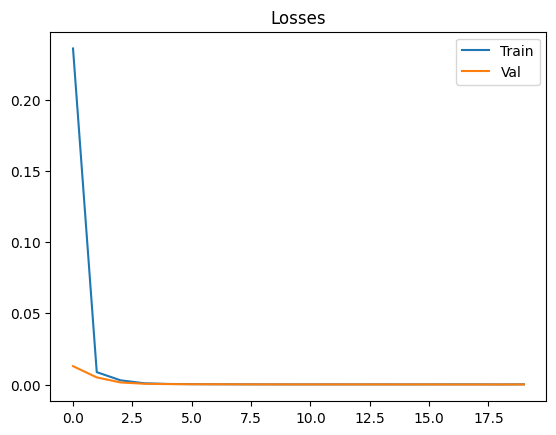

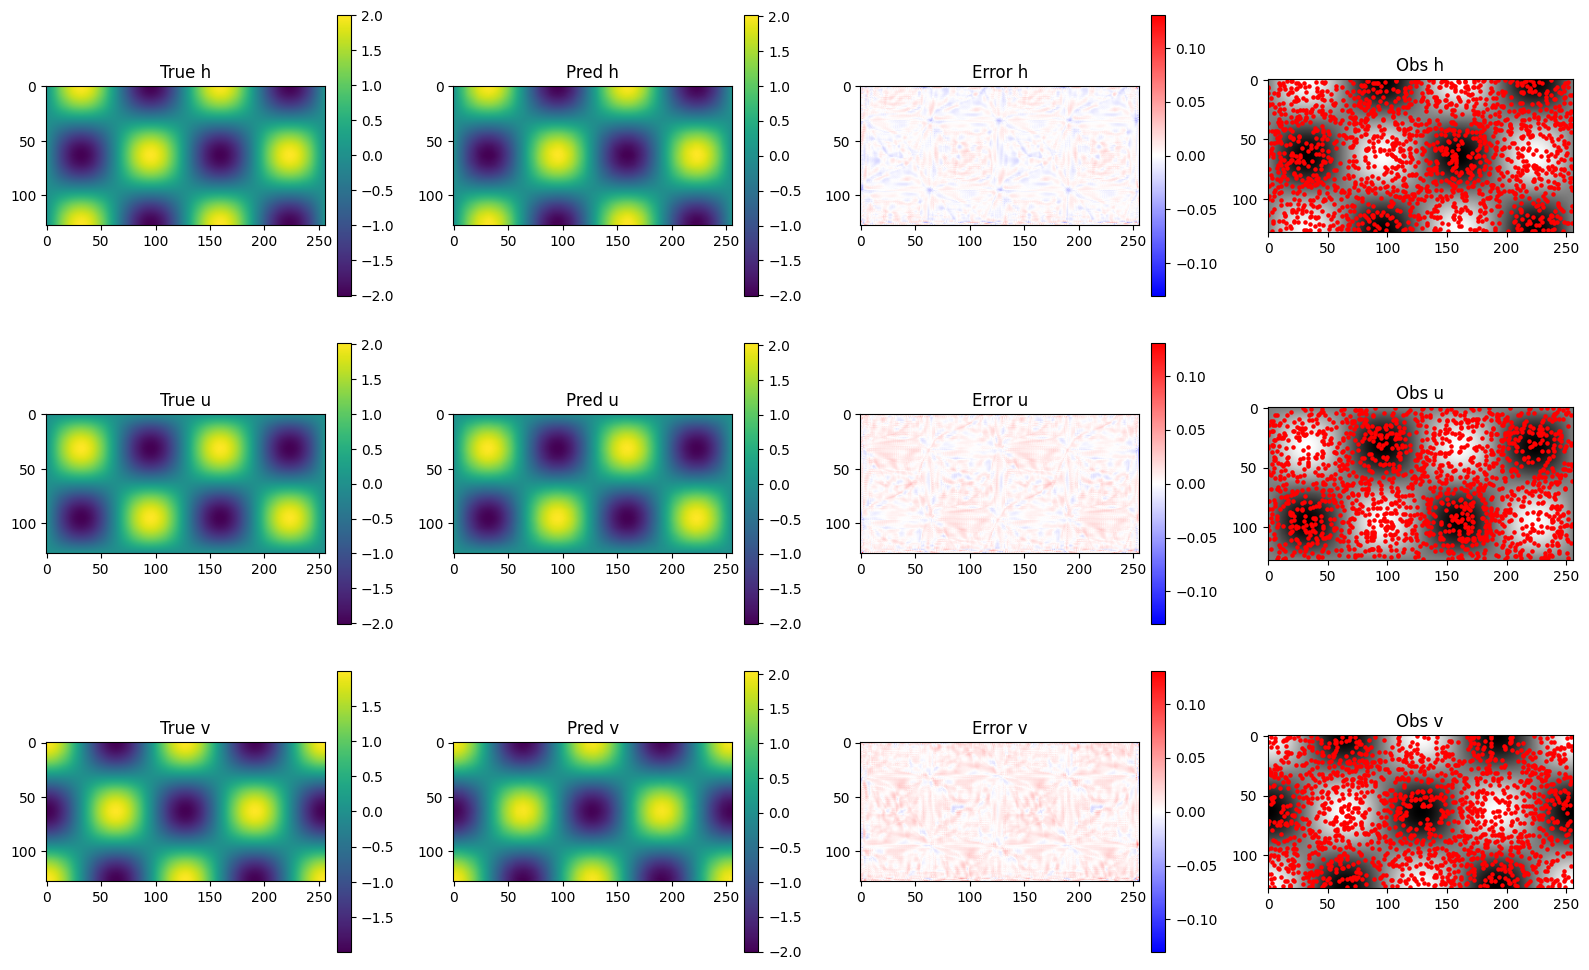

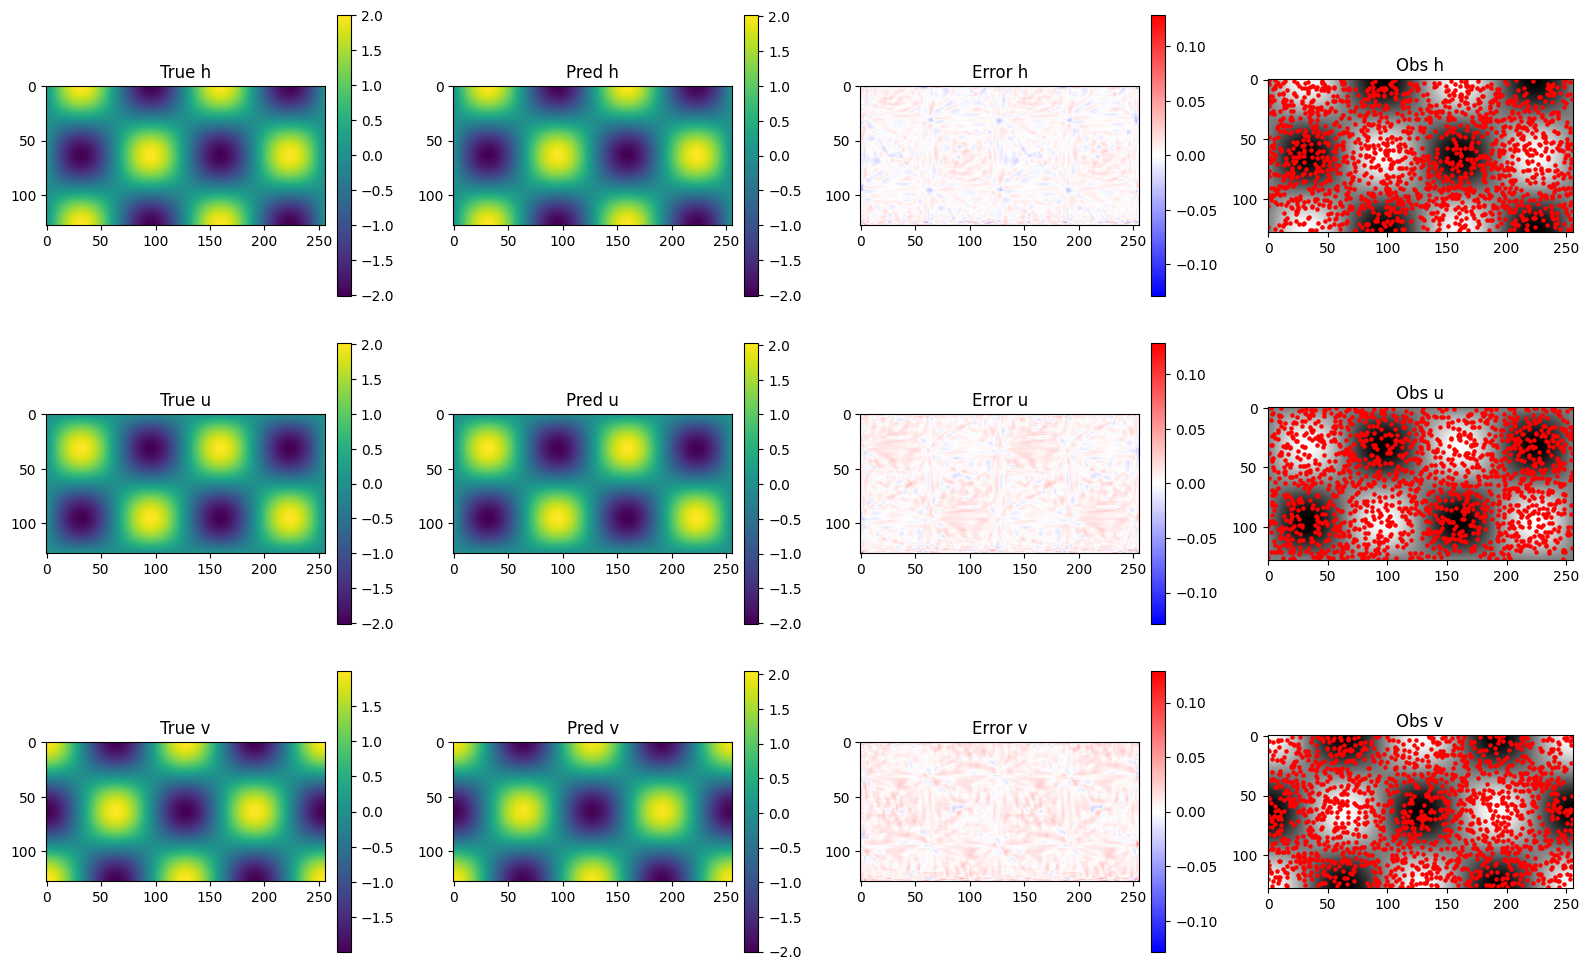

In [7]:

# ----------------------------
# 1. Imports
# ----------------------------
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# ----------------------------
# 2. Synthetic field generators
# ----------------------------
def generate_field(H, W, scale=10.0):
    """Generate smooth wave-like random field h(x,y)."""
    x = np.linspace(0, 4*np.pi, W)
    y = np.linspace(0, 2*np.pi, H)
    X, Y = np.meshgrid(x, y)
    base = np.sin(X) * np.cos(Y)
    noise = gaussian_filter(np.random.randn(H, W), sigma=scale)
    return base + 0.1 * noise

def generate_wind(h, g=9.81, f=1e-4, noise_level=0.05):
    """Generate winds from geostrophic balance + perturbations."""
    dh_dy, dh_dx = np.gradient(h)
    u = -(g/f) * dh_dy
    v =  (g/f) * dh_dx
    u += noise_level * gaussian_filter(np.random.randn(*h.shape), sigma=5)
    v += noise_level * gaussian_filter(np.random.randn(*h.shape), sigma=5)
    return u, v

def normalize_fields(X, y):
    X_norm = X.copy()
    y_norm = y.copy()
    for k in range(X.shape[0]):  # input channels
        mean = X[k].mean()
        std  = X[k].std()
        X_norm[k] = (X[k] - mean) / std
    for k in range(y.shape[0]):  # output channels
        mean = y[k].mean()
        std  = y[k].std()
        y_norm[k] = (y[k] - mean) / std
    return X_norm, y_norm

# ----------------------------
# 3. Dataset
# ----------------------------
class ShallowWaterDataset(Dataset):
    def __init__(self, num_samples, H, W):
        self.num_samples = num_samples
        self.H, self.W = H, W
        self.X_data, self.y_data = self._generate_data()

    def _generate_data(self):
        X_list, y_list = [], []
        for _ in range(self.num_samples):
            h = generate_field(self.H, self.W, scale=15.0)
            u, v = generate_wind(h)
            o1 = h * u
            o2 = h * v
            X = np.stack([h, u, v, o1, o2], axis=0)  # 5-channel input
            y = np.stack([h, u, v], axis=0)          # 3-channel output

            X, y = normalize_fields(X, y)

            X_list.append(X)
            y_list.append(y)
        return np.array(X_list), np.array(y_list)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        X = torch.tensor(self.X_data[idx], dtype=torch.float32)
        y = torch.tensor(self.y_data[idx], dtype=torch.float32)
        return X, y

# ----------------------------
# 4. U-Net
# ----------------------------

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=5, out_channels=3):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec2 = DoubleConv(64, 32)
        self.final = nn.Conv2d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d1 = self.up1(e3)
        d1 = self.dec1(torch.cat([d1, e2], dim=1))
        d2 = self.up2(d1)
        d2 = self.dec2(torch.cat([d2, e1], dim=1))
        return self.final(d2)

# ----------------------------
# 5. Training loop
# ----------------------------
def train_model(model, train_loader, test_loader, device, epochs=20):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        run_loss = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            run_loss += loss.item()
        train_losses.append(run_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                val_loss += criterion(model(X), y).item()
        test_losses.append(val_loss / len(test_loader))

        print(f"Epoch {epoch+1}/{epochs}: Train {train_losses[-1]:.6f}, Val {test_losses[-1]:.6f}")

    return train_losses, test_losses

# ----------------------------
# 6. Plot final results
# ----------------------------
def show_final_results(model, data_loader, device, num_samples=2, obs_fraction=0.05):
    model.eval()
    X_batch, y_batch = next(iter(data_loader))
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    with torch.no_grad():
        y_pred_batch = model(X_batch)

    for i in range(min(num_samples, X_batch.shape[0])):
        true_f = y_batch[i].cpu().numpy()
        pred_f = y_pred_batch[i].cpu().numpy()
        err_f  = pred_f - true_f
        vmax = np.max(np.abs(err_f))

        # Synthetic observation mask for plotting only
        H, W = true_f.shape[1], true_f.shape[2]
        obs_mask = np.zeros((3, H, W))
        num_obs = int(obs_fraction * H * W)
        for k in range(3):
            yy = np.random.randint(0, H, size=num_obs)
            xx = np.random.randint(0, W, size=num_obs)
            obs_mask[k, yy, xx] = 1

        fig, axes = plt.subplots(3, 4, figsize=(16, 10))
        titles = ["h", "u", "v"]

        for k in range(3):
            im0 = axes[k,0].imshow(true_f[k], cmap="viridis")
            axes[k,0].set_title(f"True {titles[k]}")
            fig.colorbar(im0, ax=axes[k,0], fraction=0.046, pad=0.04)

            im1 = axes[k,1].imshow(pred_f[k], cmap="viridis")
            axes[k,1].set_title(f"Pred {titles[k]}")
            fig.colorbar(im1, ax=axes[k,1], fraction=0.046, pad=0.04)

            im2 = axes[k,2].imshow(err_f[k], cmap="bwr", vmin=-vmax, vmax=vmax)
            axes[k,2].set_title(f"Error {titles[k]}")
            fig.colorbar(im2, ax=axes[k,2], fraction=0.046, pad=0.04)

            axes[k,3].imshow(true_f[k], cmap="gray")
            yy, xx = np.where(obs_mask[k] > 0)
            axes[k,3].scatter(xx, yy, c="red", s=5)
            axes[k,3].set_title(f"Obs {titles[k]}")

        plt.tight_layout()
        plt.show()

# ----------------------------
# 7. Main
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

H, W = 128, 256
train_data = ShallowWaterDataset(num_samples=200, H=H, W=W)
test_data  = ShallowWaterDataset(num_samples=20, H=H, W=W)

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=4, shuffle=False)

model = UNet(in_channels=5, out_channels=3).to(device)
train_losses, test_losses = train_model(model, train_loader, test_loader, device, epochs=20)

# Plot losses
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Val")
plt.legend(); plt.title("Losses"); plt.show()

# Show final predictions + error + synthetic observations
show_final_results(model, test_loader, device, num_samples=2, obs_fraction=0.05)

# Clean version

Using device: cuda
Epoch 1/20: Train 0.227403, Val 0.016978
Epoch 2/20: Train 0.012002, Val 0.008499
Epoch 3/20: Train 0.005582, Val 0.002829
Epoch 4/20: Train 0.001559, Val 0.000791
Epoch 5/20: Train 0.000504, Val 0.000414
Epoch 6/20: Train 0.000281, Val 0.000207
Epoch 7/20: Train 0.000185, Val 0.000154
Epoch 8/20: Train 0.000140, Val 0.000121
Epoch 9/20: Train 0.000115, Val 0.000138
Epoch 10/20: Train 0.000100, Val 0.000089
Epoch 11/20: Train 0.000090, Val 0.000074
Epoch 12/20: Train 0.000085, Val 0.000101
Epoch 13/20: Train 0.000069, Val 0.000067
Epoch 14/20: Train 0.000072, Val 0.000056
Epoch 15/20: Train 0.000062, Val 0.000056
Epoch 16/20: Train 0.000077, Val 0.000063
Epoch 17/20: Train 0.000048, Val 0.000051
Epoch 18/20: Train 0.000061, Val 0.000057
Epoch 19/20: Train 0.000055, Val 0.000046
Epoch 20/20: Train 0.000045, Val 0.000047


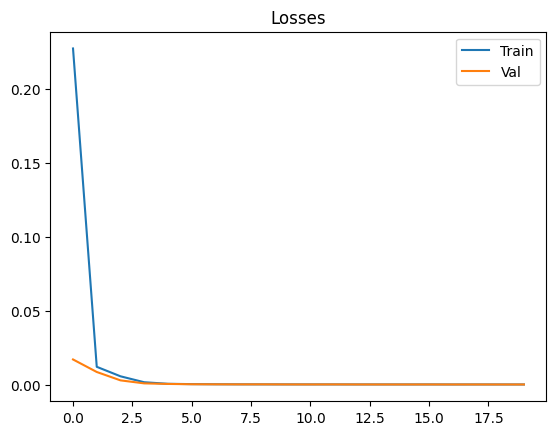

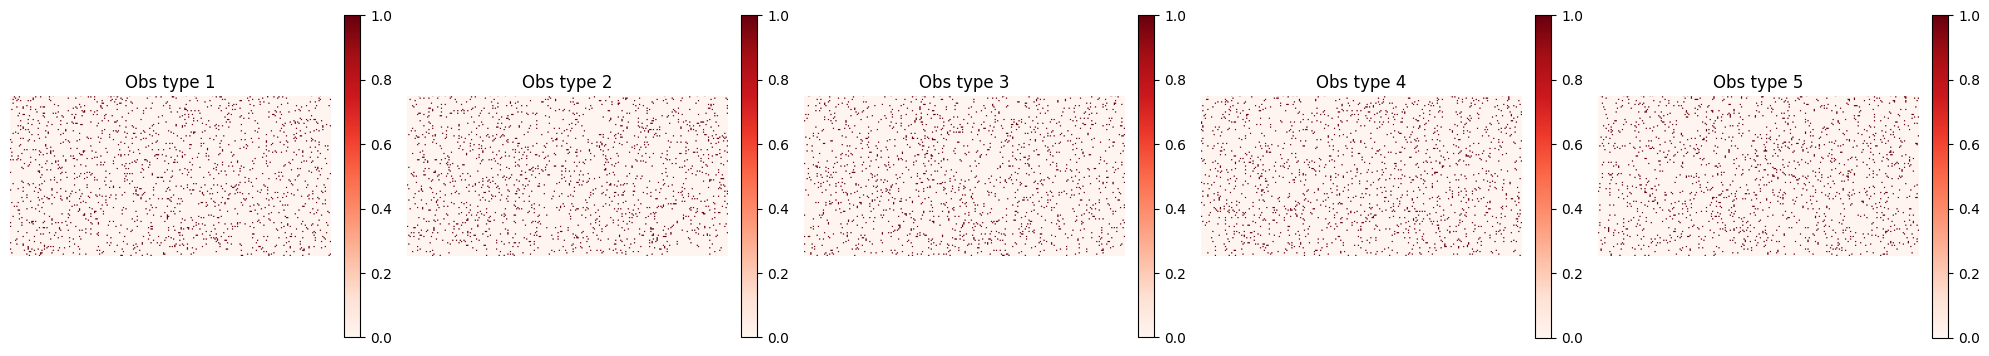

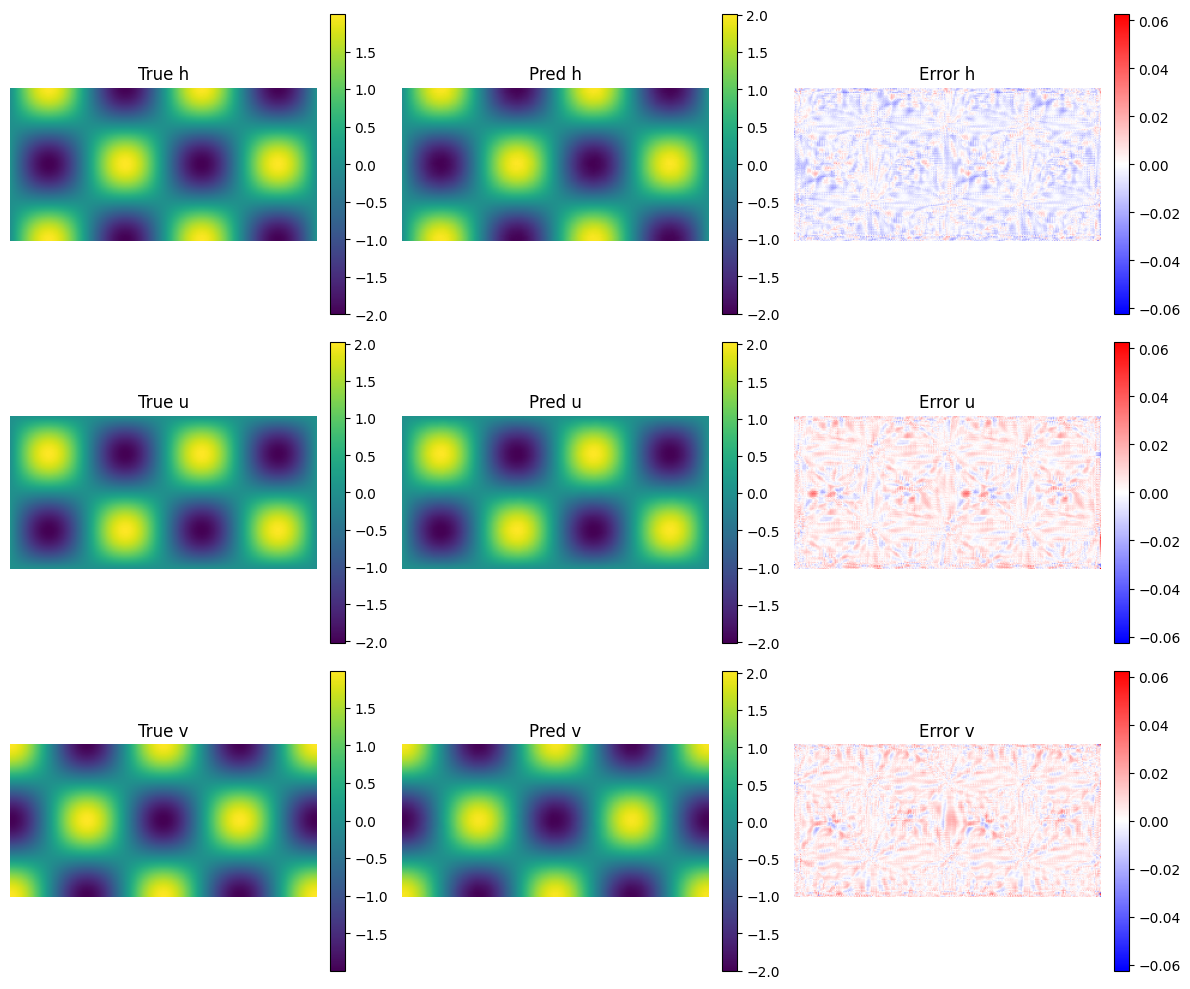

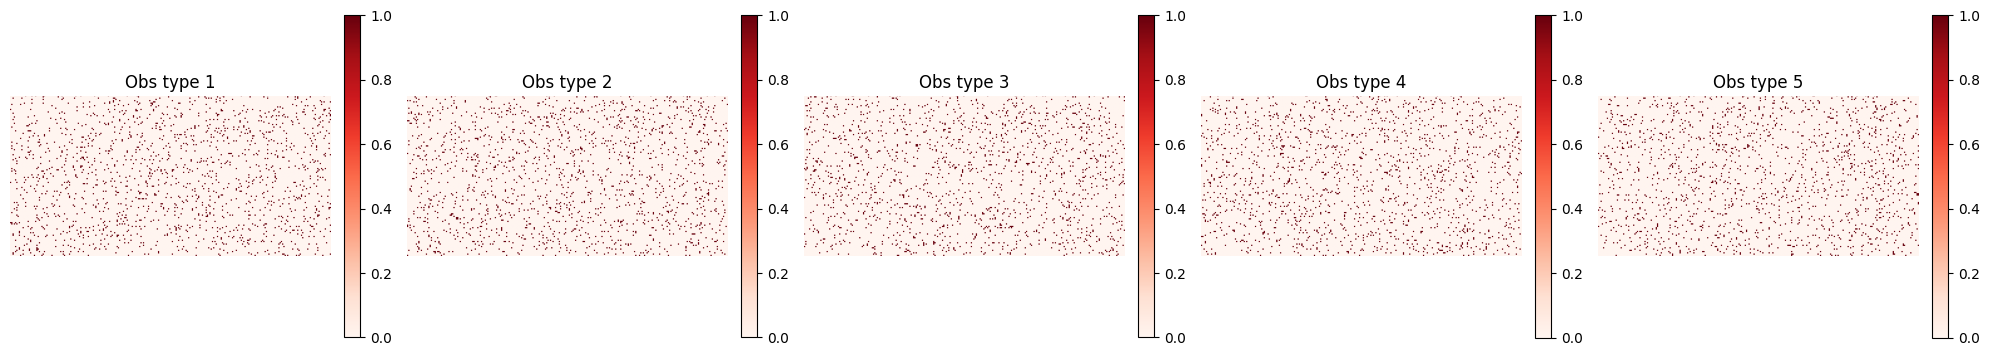

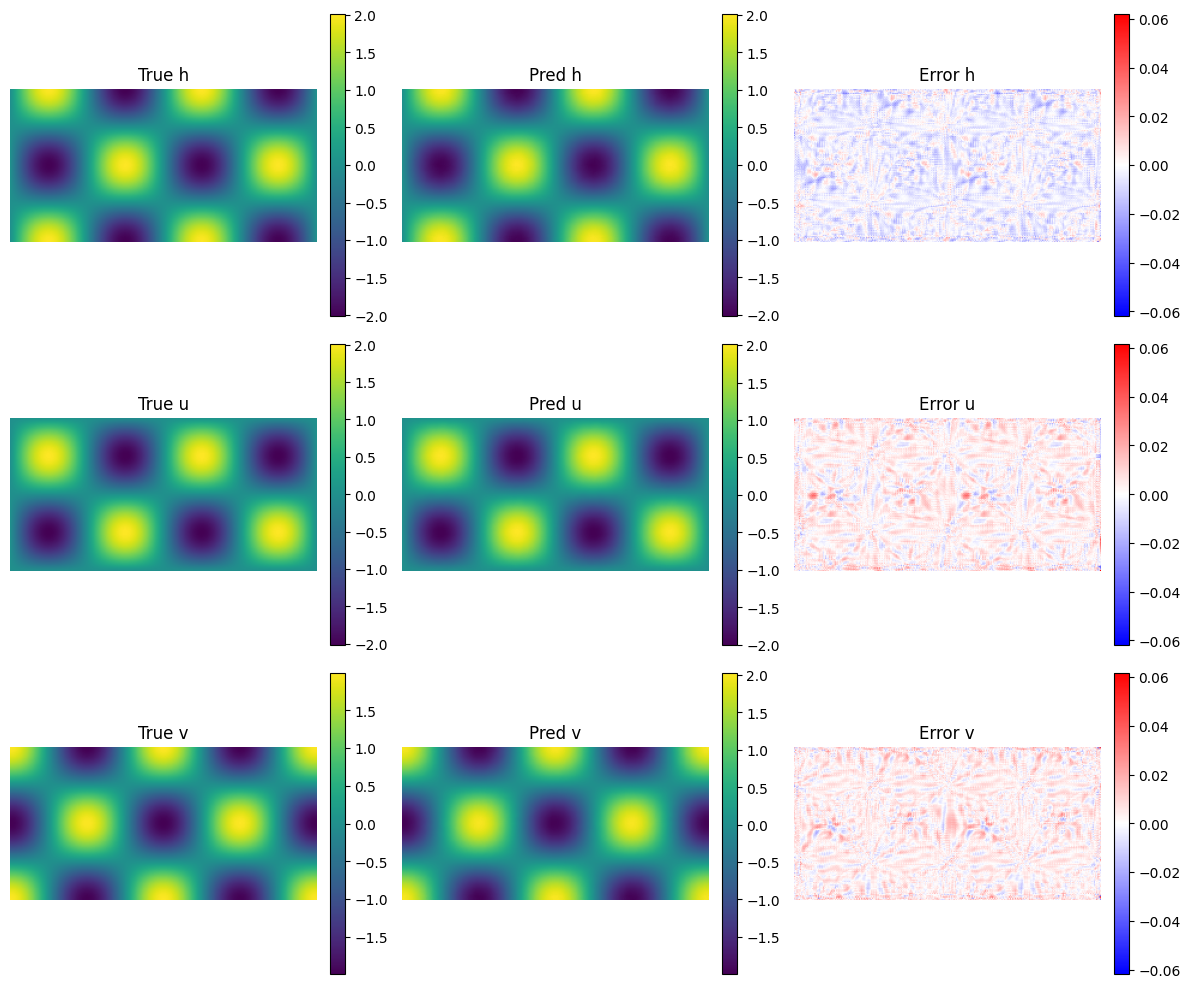

In [12]:
# ----------------------------
# 1. Imports
# ----------------------------
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# ----------------------------
# 2. Synthetic field generators
# ----------------------------
def generate_field(H, W, scale=10.0):
    x = np.linspace(0, 4*np.pi, W)
    y = np.linspace(0, 2*np.pi, H)
    X, Y = np.meshgrid(x, y)
    base = np.sin(X) * np.cos(Y)
    noise = gaussian_filter(np.random.randn(H, W), sigma=scale)
    return base + 0.1 * noise

def generate_wind(h, g=9.81, f=1e-4, noise_level=0.05):
    dh_dy, dh_dx = np.gradient(h)
    u = -(g/f) * dh_dy
    v =  (g/f) * dh_dx
    u += noise_level * gaussian_filter(np.random.randn(*h.shape), sigma=5)
    v += noise_level * gaussian_filter(np.random.randn(*h.shape), sigma=5)
    return u, v

# ----------------------------
# 3. Normalization
# ----------------------------
def normalize_fields(X, y):
    X_norm = X.copy()
    y_norm = y.copy()
    for k in range(X.shape[0]):  # input channels
        mean = X[k].mean()
        std  = X[k].std()
        X_norm[k] = (X[k] - mean) / std
    for k in range(y.shape[0]):  # output channels
        mean = y[k].mean()
        std  = y[k].std()
        y_norm[k] = (y[k] - mean) / std
    return X_norm, y_norm

# ----------------------------
# 4. Dataset
# ----------------------------
class ShallowWaterDataset(Dataset):
    def __init__(self, num_samples, H, W):
        self.num_samples = num_samples
        self.H, self.W = H, W
        self.X_data, self.y_data = self._generate_data()

    def _generate_data(self):
        X_list, y_list = [], []
        for _ in range(self.num_samples):
            h = generate_field(self.H, self.W, scale=15.0)
            u, v = generate_wind(h)
            o1 = h * u
            o2 = h * v
            X = np.stack([h, u, v, o1, o2], axis=0)
            y = np.stack([h, u, v], axis=0)
            # Normalize channels
            X, y = normalize_fields(X, y)
            X_list.append(X)
            y_list.append(y)
        return np.array(X_list), np.array(y_list)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        X = torch.tensor(self.X_data[idx], dtype=torch.float32)
        y = torch.tensor(self.y_data[idx], dtype=torch.float32)
        return X, y

# ----------------------------
# 5. U-Net
# ----------------------------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_channels=5, out_channels=3):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)
        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.dec2 = DoubleConv(64, 32)
        self.final = nn.Conv2d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        d1 = self.up1(e3)
        d1 = self.dec1(torch.cat([d1, e2], dim=1))
        d2 = self.up2(d1)
        d2 = self.dec2(torch.cat([d2, e1], dim=1))
        return self.final(d2)

# ----------------------------
# 6. Training loop
# ----------------------------
def train_model(model, train_loader, test_loader, device, epochs=20):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    train_losses, test_losses = [], []

    for epoch in range(epochs):
        model.train()
        run_loss = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            run_loss += loss.item()
        train_losses.append(run_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                val_loss += criterion(model(X), y).item()
        test_losses.append(val_loss / len(test_loader))

        print(f"Epoch {epoch+1}/{epochs}: Train {train_losses[-1]:.6f}, Val {test_losses[-1]:.6f}")

    return train_losses, test_losses

# ----------------------------
# 7. Plot final results
# ----------------------------
def show_final_results(model, data_loader, device, num_samples=2, obs_fraction=0.05, num_obs_types=5):
    model.eval()
    X_batch, y_batch = next(iter(data_loader))
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    with torch.no_grad():
        y_pred_batch = model(X_batch)

    for i in range(min(num_samples, X_batch.shape[0])):
        true_f = y_batch[i].cpu().numpy()
        pred_f = y_pred_batch[i].cpu().numpy()
        err_f  = pred_f - true_f
        vmax = np.max(np.abs(err_f))

        H, W = true_f.shape[1], true_f.shape[2]

        # Synthetic observation masks for 5 types
        obs_masks = np.zeros((num_obs_types, H, W))
        num_obs = int(obs_fraction * H * W)
        for k in range(num_obs_types):
            yy = np.random.randint(0, H, size=num_obs)
            xx = np.random.randint(0, W, size=num_obs)
            obs_masks[k, yy, xx] = 1

        # ---- First row: observations ----
        fig_obs, axes_obs = plt.subplots(1, num_obs_types, figsize=(4*num_obs_types, 4))
        for obs_idx in range(num_obs_types):
            im = axes_obs[obs_idx].imshow(obs_masks[obs_idx], cmap="Reds", vmin=0, vmax=1)
            axes_obs[obs_idx].set_title(f"Obs type {obs_idx+1}")
            axes_obs[obs_idx].axis("off")
            fig_obs.colorbar(im, ax=axes_obs[obs_idx], fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()
        plt.close(fig_obs)

        # ---- Second row: True / Pred / Error per channel ----
        fig_sol, axes_sol = plt.subplots(3, 3, figsize=(12, 10))
        titles = ["h", "u", "v"]
        for k in range(3):
            # True
            im0 = axes_sol[k,0].imshow(true_f[k], cmap="viridis")
            axes_sol[k,0].set_title(f"True {titles[k]}")
            fig_sol.colorbar(im0, ax=axes_sol[k,0], fraction=0.046, pad=0.04)
            # Pred
            im1 = axes_sol[k,1].imshow(pred_f[k], cmap="viridis")
            axes_sol[k,1].set_title(f"Pred {titles[k]}")
            fig_sol.colorbar(im1, ax=axes_sol[k,1], fraction=0.046, pad=0.04)
            # Error
            im2 = axes_sol[k,2].imshow(err_f[k], cmap="bwr", vmin=-vmax, vmax=vmax)
            axes_sol[k,2].set_title(f"Error {titles[k]}")
            fig_sol.colorbar(im2, ax=axes_sol[k,2], fraction=0.046, pad=0.04)

            for j in range(3):
                axes_sol[k,j].axis("off")
        plt.tight_layout()
        plt.show()
def show_final_results1(model, data_loader, device, num_samples=2, obs_fraction=0.05, num_obs_types=5):
    model.eval()
    X_batch, y_batch = next(iter(data_loader))
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    with torch.no_grad():
        y_pred_batch = model(X_batch)

    for i in range(min(num_samples, X_batch.shape[0])):
        true_f = y_batch[i].cpu().numpy()
        pred_f = y_pred_batch[i].cpu().numpy()
        err_f  = pred_f - true_f
        vmax = np.max(np.abs(err_f))

        H, W = true_f.shape[1], true_f.shape[2]

        # Synthetic observation masks for 5 types
        obs_masks = np.zeros((num_obs_types, H, W))
        num_obs = int(obs_fraction * H * W)
        for k in range(num_obs_types):
            yy = np.random.randint(0, H, size=num_obs)
            xx = np.random.randint(0, W, size=num_obs)
            obs_masks[k, yy, xx] = 1

        fig, axes = plt.subplots(3, 4+num_obs_types, figsize=(4*(4+num_obs_types), 10))
        titles = ["h", "u", "v"]

        for k in range(3):
            # --- Observations first ---
            for obs_idx in range(num_obs_types):
                axes[k, obs_idx].imshow(true_f[k], cmap="gray")
                yy, xx = np.where(obs_masks[obs_idx] > 0)
                # simple error bar as vertical line
                err = 0.05 * np.max(true_f[k])
                for x, y in zip(xx, yy):
                    axes[k, obs_idx].errorbar(x, y, yerr=err, fmt='o', color='red', markersize=3)
                axes[k, obs_idx].set_title(f"Obs {obs_idx+1} ({titles[k]})")
                axes[k, obs_idx].axis("off")

            # --- True field ---
            im0 = axes[k, num_obs_types].imshow(true_f[k], cmap="viridis")
            axes[k, num_obs_types].set_title(f"True {titles[k]}")
            fig.colorbar(im0, ax=axes[k, num_obs_types], fraction=0.046, pad=0.04)

            # --- Prediction ---
            im1 = axes[k, num_obs_types+1].imshow(pred_f[k], cmap="viridis")
            axes[k, num_obs_types+1].set_title(f"Pred {titles[k]}")
            fig.colorbar(im1, ax=axes[k, num_obs_types+1], fraction=0.046, pad=0.04)

            # --- Error ---
            im2 = axes[k, num_obs_types+2].imshow(err_f[k], cmap="bwr", vmin=-vmax, vmax=vmax)
            axes[k, num_obs_types+2].set_title(f"Error {titles[k]}")
            fig.colorbar(im2, ax=axes[k, num_obs_types+2], fraction=0.046, pad=0.04)

        plt.tight_layout()
        plt.show()
        plt.close(fig)
def show_final_results0(model, data_loader, device, num_samples=2, obs_fraction=0.05):
    model.eval()
    X_batch, y_batch = next(iter(data_loader))
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    with torch.no_grad():
        y_pred_batch = model(X_batch)

    for i in range(min(num_samples, X_batch.shape[0])):
        true_f = y_batch[i].cpu().numpy()
        pred_f = y_pred_batch[i].cpu().numpy()
        err_f  = pred_f - true_f
        vmax = np.max(np.abs(err_f))

        # Synthetic observation mask
        H, W = true_f.shape[1], true_f.shape[2]
        obs_mask = np.zeros((3, H, W))
        num_obs = int(obs_fraction * H * W)
        for k in range(3):
            yy = np.random.randint(0, H, size=num_obs)
            xx = np.random.randint(0, W, size=num_obs)
            obs_mask[k, yy, xx] = 1

        fig, axes = plt.subplots(3, 4, figsize=(16, 10))
        titles = ["h", "u", "v"]

        for k in range(3):
            im0 = axes[k,0].imshow(true_f[k], cmap="viridis")
            axes[k,0].set_title(f"True {titles[k]}")
            fig.colorbar(im0, ax=axes[k,0], fraction=0.046, pad=0.04)

            im1 = axes[k,1].imshow(pred_f[k], cmap="viridis")
            axes[k,1].set_title(f"Pred {titles[k]}")
            fig.colorbar(im1, ax=axes[k,1], fraction=0.046, pad=0.04)

            im2 = axes[k,2].imshow(err_f[k], cmap="bwr", vmin=-vmax, vmax=vmax)
            axes[k,2].set_title(f"Error {titles[k]}")
            fig.colorbar(im2, ax=axes[k,2], fraction=0.046, pad=0.04)

            axes[k,3].imshow(true_f[k], cmap="gray")
            yy, xx = np.where(obs_mask[k] > 0)
            #
            err = 0.05 * np.max(true_f[k])
            # Plot each observation with a small vertical line as error bar
            for x, y in zip(xx, yy):
              axes[k,3].errorbar(x, y, yerr=err, fmt='o', color='red', markersize=3)

            axes[k,3].set_title(f"Obs {titles[k]}")

            #
            axes[k,3].scatter(xx, yy, c="red", s=5)
            axes[k,3].set_title(f"Obs {titles[k]}")

        plt.tight_layout()
        plt.show()
        plt.close(fig)  # prevents duplicate figures

# ----------------------------
# 8. Main
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

H, W = 128, 256
train_data = ShallowWaterDataset(num_samples=200, H=H, W=W)
test_data  = ShallowWaterDataset(num_samples=20, H=H, W=W)

train_loader = DataLoader(train_data, batch_size=4, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=4, shuffle=False)

model = UNet(in_channels=5, out_channels=3).to(device)
train_losses, test_losses = train_model(model, train_loader, test_loader, device, epochs=20)

# Plot losses
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Val")
plt.legend(); plt.title("Losses"); plt.show()

# Show final predictions + error + synthetic observations
show_final_results(model, test_loader, device, num_samples=2, obs_fraction=0.05)